RATINGS
Mean rating:  1.0891089108910892
Mean food_rating:  1.5693069306930694
Mean service_rating:  1.1782178217821782


Total number of groups that visited the restaurant:  25


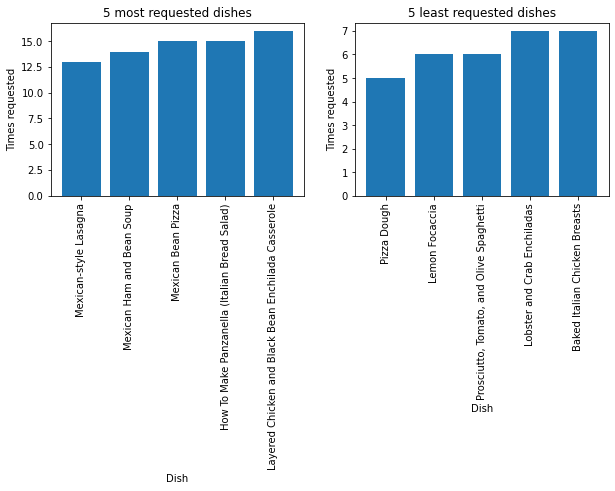

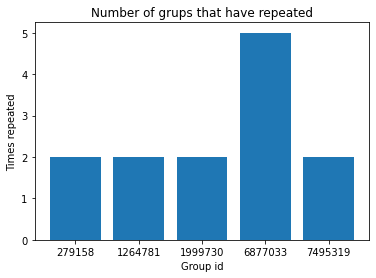

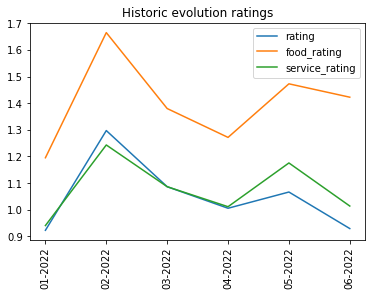

In [101]:
from logging import raiseExceptions
import re
from psycopg2 import connect
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import datetime 
from dateutil.relativedelta import relativedelta


conn = connect(
    dbname = "postgres",
    user = "postgres",
    host = 'localhost',
    port= '5432',
    password = 'FDP'
)

cursor = conn.cursor()

def restaurant_analysis(name_restaurant, start, stop):

    cursor.execute(f"SELECT * FROM ticket where place = '{name_restaurant}' and date between '{start}' and '{stop}'")
    column_names = [desc[0] for desc in cursor.description]
    restaurant_tiquets = pd.DataFrame(cursor, columns=column_names)
    list_tiquets = restaurant_tiquets['ticket_id'].unique().tolist()
    cursor.execute(f"SELECT * FROM product where ticket_id in {tuple(list_tiquets)}") #where ticket_id in {tuple(list_tiquets)}
    column_names = [desc[0] for desc in cursor.description]
    products_restaurant = pd.DataFrame(cursor, columns=column_names)
    groups_totals = len(restaurant_tiquets)
    repetits = restaurant_tiquets.groupby('group_id')['group_id'].count()
    repetits = repetits[repetits > 1]
    cursor.execute(f"SELECT * FROM ticket where place = '{name_restaurant}'")
    column_names = [desc[0] for desc in cursor.description]
    historic_tiquets = pd.DataFrame(cursor, columns=column_names)
    cursor.execute(f"SELECT * FROM product")
    column_names = [desc[0] for desc in cursor.description]
    historic_restaurant = pd.DataFrame(cursor, columns=column_names)
    historic_ratings = historic_tiquets.merge(historic_restaurant, on='ticket_id')
    historic_ratings['date'] = pd.to_datetime(historic_ratings['date'], utc=True)
    historic_ratings['date'] = historic_ratings['date'].dt.strftime('%m-%Y')
    historic_ratings = historic_ratings.sort_values(by='date')
    stop_2 = pd.to_datetime(stop, utc=True)
    stop_2 = stop_2.strftime('%m-%Y')
    historic_ratings = historic_ratings[historic_ratings['date'] <= stop_2]
    
    print("RATINGS")
    print("Mean rating: ", products_restaurant['rating'].mean())
    print("Mean food_rating: ", products_restaurant['food_rating'].mean())
    print("Mean service_rating: ", products_restaurant['service_rating'].mean())
    print("\n")
    print("Total number of groups that visited the restaurant: ", groups_totals)
    f = plt.figure(figsize=(10, 7))

    f.add_subplot(2,2,1)
    plt.title("5 most requested dishes")
    plt.bar(products_restaurant['item'].value_counts().sort_values()[-5:].index, products_restaurant['item'].value_counts().sort_values()[-5:].values)
    plt.ylabel("Times requested")
    plt.xlabel("Dish")
    plt.xticks(rotation=90)    
    
    f.add_subplot(2,2,2)
    plt.title("5 least requested dishes")
    plt.bar(products_restaurant['item'].value_counts().sort_values()[:5].index, products_restaurant['item'].value_counts().sort_values()[:5].values)
    plt.ylabel("Times requested")
    plt.xlabel("Dish")
    plt.xticks(rotation=90)
    plt.show()
    
    f.add_subplot(2,2,3)
    plt.title("Number of grups that have repeated")
    x_pos = np.arange(len(repetits))
    plt.bar(x_pos, repetits.values.tolist())
    plt.xticks(x_pos, repetits.index.tolist())
    plt.ylabel("Times repeated")
    plt.xlabel("Group id")
    plt.show()

    f.add_subplot(2,2,4)
    plt.title("Historic evolution ratings")
    plt.plot(historic_ratings['date'].unique(), historic_ratings.groupby('date')['rating'].mean(), label = "rating")
    plt.plot(historic_ratings['date'].unique(), historic_ratings.groupby('date')['food_rating'].mean(), label = "food_rating")
    plt.plot(historic_ratings['date'].unique(), historic_ratings.groupby('date')['service_rating'].mean(), label = "service_rating")

    plt.xticks(rotation=90)
    plt.legend()
    
    
                                                        

if __name__ == '__main__':
    stop = datetime.date.today()
    stop = datetime.date(stop.year, stop.month, 1)
    start = stop + relativedelta(months=-1)

    restaurant_analysis('Gorditas Dona Tota', start, stop)